<a href="https://colab.research.google.com/github/yilmajung/KM4D_v0/blob/main/ksp_pilot_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KSP Knowledge Extraction - Pilot Study

Complete Implementation for Google Colab

**PILOT STUDY SETUP:**
- 4 KSP advisory reports
- 2 development economics textbooks
- Dual-collection RAG with ChromaDB
- LLM extraction using Anthropic Claude API
- Full evaluation and visualization

**GOOGLE COLAB USAGE:**
- Runtime -> Change runtime type -> T4 GPU (for faster embeddings)
- Files will be saved to Google Drive for persistence

## Section 1: Setup & Installation

In [1]:
# Install required packages
!pip install -q pymupdf pdfplumber sentence-transformers chromadb anthropic pandas numpy scikit-learn matplotlib seaborn plotly networkx umap-learn python-dotenv

In [2]:
# Mount Google Drive for file persistence
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Create project directory in Google Drive
import os
project_dir = '/content/drive/MyDrive/KM4D_v0'
os.makedirs(project_dir, exist_ok=True)
os.makedirs(f'{project_dir}/data/raw/ksp_reports', exist_ok=True)
os.makedirs(f'{project_dir}/data/raw/textbooks', exist_ok=True)
os.makedirs(f'{project_dir}/data/processed', exist_ok=True)
os.makedirs(f'{project_dir}/data/results', exist_ok=True)
os.makedirs(f'{project_dir}/data/gold_standard', exist_ok=True)
os.makedirs(f'{project_dir}/vector_db', exist_ok=True)

print("\u2713 Project directory created in Google Drive")
print(f"  Location: {project_dir}")

✓ Project directory created in Google Drive
  Location: /content/drive/MyDrive/KM4D_v0


## Section 2: Configuration

In [4]:
import os
from dataclasses import dataclass
from typing import List, Dict, Optional
import json

@dataclass
class Config:
    """Central configuration for the pilot study."""

    # Directories
    project_dir: str = project_dir
    ksp_dir: str = f"{project_dir}/data/raw/ksp_reports"
    textbook_dir: str = f"{project_dir}/data/raw/textbooks"
    processed_dir: str = f"{project_dir}/data/processed"
    results_dir: str = f"{project_dir}/data/results"
    vector_db_dir: str = f"{project_dir}/vector_db"

    # Chunking parameters (ksp: 512 tokens, textbook: 768 tokens)
    ksp_chunk_size: int = 512
    textbook_chunk_size: int = 768
    chunk_overlap: int = 50

    # Embedding model
    embedding_model: str = "sentence-transformers/all-MiniLM-L6-v2"

    # LLM API
    llm_provider: str = "anthropic"  # or "openai"
    llm_model: str = "claude-sonnet-4-20250514"
    temperature: float = 0.1
    max_tokens: int = 4000

    # Retrieval parameters
    ksp_top_k: int = 5
    textbook_top_k: int = 3

    # Collections
    ksp_collection: str = "ksp_reports_pilot"
    textbook_collection: str = "textbooks_pilot"

config = Config()

In [5]:
# API Key Setup
from google.colab import userdata

# Get API key from Colab secrets
# Go to: \ud83d\udd11 icon in left sidebar -> Add new secret
# Name: ANTHROPIC_API_KEY, Value: your API key
try:
    ANTHROPIC_API_KEY = userdata.get('ANTHROPIC_API_KEY')
    print("\u2713 API key loaded from Colab secrets")
except:
    print("\u26a0 No API key found in Colab secrets")
    print("Please add ANTHROPIC_API_KEY in the secrets panel (\ud83d\udd11 icon)")
    ANTHROPIC_API_KEY = input("Or enter API key here: ")

✓ API key loaded from Colab secrets


## Section 3: PDF Processing

In [6]:
import fitz  # PyMuPDF
import pdfplumber
import re
from pathlib import Path
from typing import List, Dict

class PDFProcessor:
    """Extract text from PDFs while preserving structure."""

    def __init__(self, pdf_path: str, source_type: str = "ksp"):
        """
        Args:
            pdf_path: Path to PDF file
            source_type: "ksp" or "textbook"
        """
        self.pdf_path = pdf_path
        self.source_type = source_type
        self.filename = Path(pdf_path).stem
        self.metadata = self._extract_metadata()

    def _extract_metadata(self) -> Dict:
        """Extract metadata from filename."""
        if self.source_type == "ksp":
            # Format: YYYY_CCC_Title.pdf
            # Example: 2015_VNM_Industrial_Policy.pdf
            pattern = r'(\d{4})_([A-Z]{3})_(.+)'
            match = re.match(pattern, self.filename)
            if match:
                return {
                    'source_type': 'ksp',
                    'year': match.group(1),
                    'country': match.group(2),
                    'title': match.group(3).replace('_', ' '),
                    'filename': self.filename
                }
        else:  # textbook
            # Format: Author_Year.pdf
            # Example: Perkins_2013.pdf
            return {
                'source_type': 'textbook',
                'filename': self.filename
            }

        return {'source_type': self.source_type, 'filename': self.filename}

    def extract_sections(self) -> List[Dict]:
        """Extract text organized by sections."""
        doc = fitz.open(self.pdf_path)
        sections = []
        current_section = {'title': 'Introduction', 'content': '', 'page': 1}

        for page_num, page in enumerate(doc, 1):
            # Extract text blocks with font information
            blocks = page.get_text("dict")["blocks"]

            for block in blocks:
                if "lines" not in block:
                    continue

                for line in block["lines"]:
                    text = ""
                    font_size = 0

                    for span in line["spans"]:
                        text += span["text"]
                        font_size = max(font_size, span["size"])

                    text = text.strip()
                    if not text:
                        continue

                    # Detect section headers (larger font, shorter text)
                    if font_size > 12 and len(text) < 100:
                        # Save previous section
                        if current_section['content'].strip():
                            sections.append(current_section)

                        # Start new section
                        current_section = {
                            'title': text,
                            'content': '',
                            'page': page_num
                        }
                    else:
                        current_section['content'] += text + "\n"

        # Add final section
        if current_section['content'].strip():
            sections.append(current_section)

        doc.close()
        return sections

    def extract_full_text(self) -> str:
        """Extract all text from PDF."""
        doc = fitz.open(self.pdf_path)
        text = ""
        for page in doc:
            text += page.get_text()
        doc.close()
        return text

    def get_page_count(self) -> int:
        """Get number of pages."""
        doc = fitz.open(self.pdf_path)
        count = len(doc)
        doc.close()
        return count

# Test PDF processing
print("Testing PDF processor...")
test_pdf = f"{config.ksp_dir}/2009_VNM_Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy_E.pdf"
if os.path.exists(test_pdf):
    processor = PDFProcessor(test_pdf, source_type="ksp")
    print(f"\u2713 Metadata: {processor.metadata}")
    sections = processor.extract_sections()
    print(f"\u2713 Extracted {len(sections)} sections")
    print(f"\u2713 Total pages: {processor.get_page_count()}")
else:
    print(f"Upload PDF to: {test_pdf}")

Testing PDF processor...
✓ Metadata: {'source_type': 'ksp', 'year': '2009', 'country': 'VNM', 'title': 'Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy E', 'filename': '2009_VNM_Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy_E'}
✓ Extracted 218 sections
✓ Total pages: 440


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Section 4: Semantic Chunking

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

ModuleNotFoundError: No module named 'langchain.text_splitter'

In [14]:
!pip install -q langchain-text-splitters

In [17]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

class SemanticChunker:
    """Create semantic chunks from extracted text."""

    def __init__(self, chunk_size: int = 512, chunk_overlap: int = 50):
        self.splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            separators=["\n\n", "\n", ". ", " ", ""],
            length_function=len
        )

    def chunk_sections(self, sections: List[Dict], metadata: Dict) -> List[Dict]:
        """Create chunks from sections with metadata."""
        chunks = []

        for section_idx, section in enumerate(sections):
            section_text = section['content']
            section_title = section['title']

            # Split section into smaller chunks if needed
            sub_chunks = self.splitter.split_text(section_text)

            for chunk_idx, chunk_text in enumerate(sub_chunks):
                chunk = {
                    'text': chunk_text,
                    'metadata': {
                        **metadata,  # Include all document metadata
                        'section_title': section_title,
                        'section_index': section_idx,
                        'section_page': section['page'],
                        'chunk_index': chunk_idx,
                        'chunk_id': f"{metadata['filename']}_s{section_idx}_c{chunk_idx}"
                    }
                }
                chunks.append(chunk)

        return chunks

# Test chunker
chunker_ksp = SemanticChunker(chunk_size=config.ksp_chunk_size)
chunker_textbook = SemanticChunker(chunk_size=config.textbook_chunk_size)
print("Chunker initialized")
print(f"  KSP chunk size: {config.ksp_chunk_size} characters")
print(f"  Textbook chunk size: {config.textbook_chunk_size} characters")

✓ Chunker initialized
  KSP chunk size: 512 characters
  Textbook chunk size: 768 characters


## Section 5: Embedding & Vector Database

In [18]:
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings
from tqdm import tqdm
import numpy as np

class VectorStore:
    """Manage embeddings and ChromaDB vector database."""

    def __init__(self, collection_name: str, persist_directory: str = None):
        """
        Args:
            collection_name: Name of the collection
            persist_directory: Where to save the database (Google Drive)
        """
        self.collection_name = collection_name

        # Initialize embedding model
        print(f"Loading embedding model: {config.embedding_model}...")
        self.embedding_model = SentenceTransformer(config.embedding_model)
        print("Embedding model loaded")

        # Initialize ChromaDB with persistence
        if persist_directory is None:
            persist_directory = config.vector_db_dir

        self.client = chromadb.Client(Settings(
            persist_directory=persist_directory,
            anonymized_telemetry=False
        ))

        # Create or get collection
        try:
            self.collection = self.client.get_collection(name=collection_name)
            print(f"Loaded existing collection: {collection_name}")
        except:
            self.collection = self.client.create_collection(
                name=collection_name,
                metadata={"description": f"Collection for {collection_name}"}
            )
            print(f"Created new collection: {collection_name}")

    def add_documents(self, chunks: List[Dict], batch_size: int = 32):
        """Add document chunks to vector database."""
        documents = [chunk['text'] for chunk in chunks]
        metadatas = [chunk['metadata'] for chunk in chunks]
        ids = [chunk['metadata']['chunk_id'] for chunk in chunks]

        print(f"Adding {len(documents)} documents to {self.collection_name}...")

        # Create embeddings in batches
        all_embeddings = []
        for i in tqdm(range(0, len(documents), batch_size), desc="Embedding"):
            batch_docs = documents[i:i+batch_size]
            embeddings = self.embedding_model.encode(
                batch_docs,
                show_progress_bar=False,
                convert_to_numpy=True
            ).tolist()
            all_embeddings.extend(embeddings)

        # Add to ChromaDB in batches
        for i in tqdm(range(0, len(documents), batch_size), desc="Storing"):
            batch_end = min(i + batch_size, len(documents))

            self.collection.add(
                documents=documents[i:batch_end],
                embeddings=all_embeddings[i:batch_end],
                metadatas=metadatas[i:batch_end],
                ids=ids[i:batch_end]
            )

        print(f"Added {len(documents)} chunks to collection")

    def search(self,
               query: str,
               n_results: int = 5,
               filter_dict: Dict = None) -> Dict:
        """Search for relevant chunks."""
        # Create query embedding
        query_embedding = self.embedding_model.encode([query])[0].tolist()

        # Search
        results = self.collection.query(
            query_embeddings=[query_embedding],
            n_results=n_results,
            where=filter_dict
        )

        return results

    def get_stats(self) -> Dict:
        """Get collection statistics."""
        count = self.collection.count()
        return {
            'collection_name': self.collection_name,
            'total_chunks': count
        }

## Section 6: Dual Vector Store Initialization

In [19]:
# Initialize vector stores
print("\n" + "="*60)
print("INITIALIZING VECTOR DATABASES")
print("="*60)

ksp_store = VectorStore(
    collection_name=config.ksp_collection,
    persist_directory=config.vector_db_dir
)

textbook_store = VectorStore(
    collection_name=config.textbook_collection,
    persist_directory=config.vector_db_dir
)

print("\n Vector stores initialized")
print(f"  ChromaDB persisted to: {config.vector_db_dir}")


INITIALIZING VECTOR DATABASES
Loading embedding model: sentence-transformers/all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding model loaded
Created new collection: ksp_reports_pilot
Loading embedding model: sentence-transformers/all-MiniLM-L6-v2...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding model loaded
Created new collection: textbooks_pilot

 Vector stores initialized
  ChromaDB persisted to: /content/drive/MyDrive/KM4D_v0/vector_db


## Section 7: Document Indexing Pipeline

In [20]:
def process_and_index_ksp_reports():
    """Process all KSP reports and add to vector database."""
    ksp_dir = Path(config.ksp_dir)
    pdf_files = list(ksp_dir.glob("*.pdf"))

    print(f"\nFound {len(pdf_files)} KSP reports")

    all_chunks = []

    for pdf_path in pdf_files:
        print(f"\nProcessing: {pdf_path.name}")

        # Extract text
        processor = PDFProcessor(str(pdf_path), source_type="ksp")
        sections = processor.extract_sections()
        print(f"  Extracted {len(sections)} sections")

        # Create chunks
        chunks = chunker_ksp.chunk_sections(sections, processor.metadata)
        print(f"  Created {len(chunks)} chunks")

        all_chunks.extend(chunks)

    # Add to vector database
    if all_chunks:
        ksp_store.add_documents(all_chunks)

        # Save processed data
        output_path = f"{config.processed_dir}/ksp_chunks.json"
        with open(output_path, 'w') as f:
            json.dump(all_chunks, f, indent=2)
        print(f"\n Saved processed chunks to: {output_path}")

    return all_chunks

def process_and_index_textbooks():
    """Process textbooks and add to vector database."""
    textbook_dir = Path(config.textbook_dir)
    pdf_files = list(textbook_dir.glob("*.pdf"))

    print(f"\nFound {len(pdf_files)} textbooks")

    all_chunks = []

    for pdf_path in pdf_files:
        print(f"\nProcessing: {pdf_path.name}")

        # Extract text
        processor = PDFProcessor(str(pdf_path), source_type="textbook")
        sections = processor.extract_sections()
        print(f"  Extracted {len(sections)} sections")

        # Create chunks (larger for textbooks)
        chunks = chunker_textbook.chunk_sections(sections, processor.metadata)
        print(f"  Created {len(chunks)} chunks")

        all_chunks.extend(chunks)

    # Add to vector database
    if all_chunks:
        textbook_store.add_documents(all_chunks)

        # Save processed data
        output_path = f"{config.processed_dir}/textbook_chunks.json"
        with open(output_path, 'w') as f:
            json.dump(all_chunks, f, indent=2)
        print(f"\nSaved processed chunks to: {output_path}")

    return all_chunks

### Run Document Indexing

In [21]:
print("\n" + "="*60)
print("PHASE 1: DOCUMENT INDEXING")
print("="*60)

# Check if PDFs are uploaded
ksp_pdfs = list(Path(config.ksp_dir).glob("*.pdf"))
textbook_pdfs = list(Path(config.textbook_dir).glob("*.pdf"))

if len(ksp_pdfs) == 0:
    print(f"\n No KSP reports found in: {config.ksp_dir}")
    print("Please upload 4 KSP PDF reports to this directory")
    print("\nTo upload:")
    print("1. Click the folder icon in the left sidebar")
    print(f"2. Navigate to: {config.ksp_dir}")
    print("3. Right-click -> Upload")
else:
    print(f"\n Found {len(ksp_pdfs)} KSP reports")
    ksp_chunks = process_and_index_ksp_reports()

if len(textbook_pdfs) == 0:
    print(f"\n No textbooks found in: {config.textbook_dir}")
    print("Please upload 2 textbook PDFs to this directory")
else:
    print(f"\n Found {len(textbook_pdfs)} textbooks")
    textbook_chunks = process_and_index_textbooks()

# Print statistics
print("\n" + "="*60)
print("INDEXING COMPLETE")
print("="*60)
print(f"\nKSP Collection: {ksp_store.get_stats()}")
print(f"Textbook Collection: {textbook_store.get_stats()}")


PHASE 1: DOCUMENT INDEXING

 Found 4 KSP reports

Found 4 KSP reports

Processing: 2014_SLV_Developing an Innovation Ecosystem... Plastics Pharmaceutical and Cosmetics and Textile Industries.pdf
  Extracted 90 sections
  Created 1083 chunks

Processing: 2023_KAZ_Project on Extending the Life of Old Power Plants and Improving Energy Efficiency of Aging Power Plants in Kazakhstan.pdf
  Extracted 57 sections
  Created 763 chunks

Processing: 2009_VNM_Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy_E.pdf
  Extracted 218 sections
  Created 2277 chunks

Processing: 2023_QAT_Climate Smart Agriculture and Indoor Farming in Qatar.pdf
  Extracted 54 sections
  Created 846 chunks
Adding 4969 documents to ksp_reports_pilot...


Storing: 100%|██████████| 156/156 [00:06<00:00, 23.19it/s]


✓ Added 4969 chunks to collection

 Saved processed chunks to: /content/drive/MyDrive/KM4D_v0/data/processed/ksp_chunks.json

 Found 2 textbooks

Found 2 textbooks

Processing: Perkins et al_2012.pdf
  Extracted 87 sections
  Created 3273 chunks

Processing: Todoro_2012.pdf
  Extracted 281 sections
  Created 3921 chunks
Adding 7194 documents to textbooks_pilot...


Storing: 100%|██████████| 225/225 [00:10<00:00, 21.84it/s]


✓ Added 7194 chunks to collection

Saved processed chunks to: /content/drive/MyDrive/KM4D_v0/data/processed/textbook_chunks.json

INDEXING COMPLETE

KSP Collection: {'collection_name': 'ksp_reports_pilot', 'total_chunks': 4969}
Textbook Collection: {'collection_name': 'textbooks_pilot', 'total_chunks': 7194}


## Section 8: LLM Extraction Setup

In [22]:
import anthropic
from typing import List, Dict
import json

class PolicyExtractor:
    """Extract structured policy information using Claude API."""

    def __init__(self, api_key: str):
        self.client = anthropic.Anthropic(api_key=api_key)
        self.model = config.llm_model

        self.extraction_prompt = """You are analyzing development policy documents to extract structured information.

CONTEXT FROM KSP REPORT:
{ksp_context}

RELATED THEORETICAL CONCEPTS (from textbooks):
{theory_context}

TASK:
Extract ALL policies, programs, or initiatives mentioned in the KSP context.

For EACH policy/program, provide:
1. policy_name: Official title or clear description
2. year_initiated: Year it started (null if not mentioned)
3. organization: Responsible government ministry/agency (null if not mentioned)
4. challenge_addressed: What development problem did it address?
5. policy_instruments: List of specific mechanisms/tools used (e.g., ["Tax incentives", "Credit allocation"])
6. sector: Economic sector (e.g., "Manufacturing", "Finance", "Agriculture")
7. development_stage: "early_industrialization", "middle_income", or "advanced" (null if unclear)
8. evidence_quote: Direct quote from KSP document supporting this (REQUIRED - must be verbatim from context)
9. related_theory: Which theoretical concept from the textbook context relates to this policy? (null if none)

OUTPUT FORMAT:
Return ONLY a valid JSON array. No markdown, no preamble, no explanation.

[
  {{
    "policy_name": "string",
    "year_initiated": integer or null,
    "organization": "string" or null,
    "challenge_addressed": "string",
    "policy_instruments": ["string", "string"],
    "sector": "string",
    "development_stage": "early_industrialization" | "middle_income" | "advanced" | null,
    "evidence_quote": "string from KSP context",
    "related_theory": "string from textbook context" or null
  }}
]

CRITICAL RULES:
- Only extract information explicitly stated in the KSP context
- Every policy MUST have an evidence_quote from the KSP context
- If information not mentioned, use null
- Extract ALL policies mentioned, not just major ones
- Return valid JSON only
- If no policies found, return: []"""

    def extract_from_contexts(self,
                              ksp_context: str,
                              theory_context: str = "") -> List[Dict]:
        """Extract policies from KSP context with theory linking."""

        prompt = self.extraction_prompt.format(
            ksp_context=ksp_context,
            theory_context=theory_context if theory_context else "No theoretical context provided"
        )

        try:
            response = self.client.messages.create(
                model=self.model,
                max_tokens=config.max_tokens,
                temperature=config.temperature,
                messages=[{
                    "role": "user",
                    "content": prompt
                }]
            )

            # Extract text from response
            content = response.content[0].text

            # Clean response (remove markdown if present)
            content = content.strip()
            if content.startswith('```json'):
                content = content[7:]
            if content.startswith('```'):
                content = content[3:]
            if content.endswith('```'):
                content = content[:-3]
            content = content.strip()

            # Parse JSON
            policies = json.loads(content)

            if not isinstance(policies, list):
                policies = [policies]

            return policies

        except json.JSONDecodeError as e:
            print(f"JSON parsing error: {e}")
            print(f"Response: {content[:200]}...")
            return []
        except Exception as e:
            print(f"Extraction error: {e}")
            return []

# Initialize extractor
extractor = PolicyExtractor(api_key=ANTHROPIC_API_KEY)
print("Policy extractor initialized")

Policy extractor initialized


## Section 9: Extraction Pipeline

In [23]:
def extract_policies_from_report(report_filename: str) -> List[Dict]:
    """Extract policies from a single KSP report with theory linking."""

    print(f"\n{'='*60}")
    print(f"EXTRACTING FROM: {report_filename}")
    print('='*60)

    # Step 1: Query KSP collection for policy-relevant passages
    ksp_queries = [
        "Korean government policy program initiative implementation",
        "ministry organization agency institution",
        "economic development challenge problem solution",
        "policy instrument mechanism tool intervention"
    ]

    all_ksp_context = set()
    for query in ksp_queries:
        results = ksp_store.search(
            query=query,
            n_results=config.ksp_top_k,
            filter_dict={'filename': report_filename}
        )
        if results['documents'][0]:
            all_ksp_context.update(results['documents'][0])

    ksp_context = "\n\n---\n\n".join(all_ksp_context)
    print(f"Retrieved {len(all_ksp_context)} unique KSP chunks")

    # Step 2: Query textbook collection for related theory
    theory_query = f"development policy economic growth industrial policy"
    theory_results = textbook_store.search(
        query=theory_query,
        n_results=config.textbook_top_k
    )

    theory_context = "\n\n---\n\n".join(theory_results['documents'][0]) if theory_results['documents'][0] else ""
    print(f"Retrieved {len(theory_results['documents'][0])} textbook chunks")

    # Step 3: Extract policies with theory linking
    print("\nExtracting policies with Claude API...")
    policies = extractor.extract_from_contexts(ksp_context, theory_context)

    # Add source metadata
    for policy in policies:
        policy['source_report'] = report_filename

    print(f"Extracted {len(policies)} policies")

    return policies

def extract_all_policies() -> List[Dict]:
    """Extract policies from all KSP reports."""
    ksp_pdfs = list(Path(config.ksp_dir).glob("*.pdf"))

    all_policies = []

    for pdf_path in ksp_pdfs:
        report_filename = pdf_path.stem
        policies = extract_policies_from_report(report_filename)
        all_policies.extend(policies)

    # Save results
    output_path = f"{config.results_dir}/extracted_policies.json"
    with open(output_path, 'w') as f:
        json.dump(all_policies, f, indent=2)

    print(f"\n{'='*60}")
    print(f"EXTRACTION COMPLETE")
    print('='*60)
    print(f"Total policies extracted: {len(all_policies)}")
    print(f"Results saved to: {output_path}")

    return all_policies

## Section 10: Run Extraction

In [24]:
print("\n" + "="*60)
print("PHASE 2: POLICY EXTRACTION")
print("="*60)

# Check if we have indexed documents
if ksp_store.get_stats()['total_chunks'] == 0:
    print("\n\u26a0 No documents indexed yet!")
    print("Please run the indexing section (Section 7) first")
else:
    # Extract policies
    extracted_policies = extract_all_policies()

    # Display sample
    if extracted_policies:
        print("\nSample extracted policy:")
        print(json.dumps(extracted_policies[0], indent=2))


PHASE 2: POLICY EXTRACTION

EXTRACTING FROM: 2014_SLV_Developing an Innovation Ecosystem... Plastics Pharmaceutical and Cosmetics and Textile Industries
Retrieved 17 unique KSP chunks
Retrieved 3 textbook chunks

Extracting policies with Claude API...
Extracted 7 policies

EXTRACTING FROM: 2023_KAZ_Project on Extending the Life of Old Power Plants and Improving Energy Efficiency of Aging Power Plants in Kazakhstan
Retrieved 18 unique KSP chunks
Retrieved 3 textbook chunks

Extracting policies with Claude API...
Extracted 8 policies

EXTRACTING FROM: 2009_VNM_Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy_E
Retrieved 20 unique KSP chunks
Retrieved 3 textbook chunks

Extracting policies with Claude API...
Extracted 5 policies

EXTRACTING FROM: 2023_QAT_Climate Smart Agriculture and Indoor Farming in Qatar
Retrieved 18 unique KSP chunks
Retrieved 3 textbook chunks

Extracting policies with Claude API...
Extracted 9 policies

EXTRACTION COMPLETE
Tota

## Section 11: Evaluation (if gold standard exists)

In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

class Evaluator:
    """Evaluate extraction quality against gold standard."""

    def __init__(self, gold_standard_path: str):
        with open(gold_standard_path) as f:
            self.gold_standard = json.load(f)

    def evaluate(self, predictions: List[Dict]) -> Dict:
        """Evaluate predictions against gold standard."""

        # Group by report
        pred_by_report = {}
        for p in predictions:
            report = p.get('source_report', 'unknown')
            if report not in pred_by_report:
                pred_by_report[report] = []
            pred_by_report[report].append(p)

        gold_by_report = {}
        for g in self.gold_standard:
            report = g.get('source_report', 'unknown')
            if report not in gold_by_report:
                gold_by_report[report] = []
            gold_by_report[report].append(g)

        # Calculate metrics for each report
        results = []
        for report in set(list(pred_by_report.keys()) + list(gold_by_report.keys())):
            preds = pred_by_report.get(report, [])
            golds = gold_by_report.get(report, [])

            # Entity-level evaluation (policy names)
            pred_names = set(p['policy_name'].lower() for p in preds)
            gold_names = set(g['policy_name'].lower() for g in golds)

            tp = len(pred_names & gold_names)
            fp = len(pred_names - gold_names)
            fn = len(gold_names - pred_names)

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            results.append({
                'report': report,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'tp': tp,
                'fp': fp,
                'fn': fn,
                'num_predicted': len(preds),
                'num_gold': len(golds)
            })

        # Calculate overall metrics
        total_tp = sum(r['tp'] for r in results)
        total_fp = sum(r['fp'] for r in results)
        total_fn = sum(r['fn'] for r in results)

        overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
        overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
        overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0

        return {
            'overall': {
                'precision': overall_precision,
                'recall': overall_recall,
                'f1': overall_f1,
                'total_predicted': sum(r['num_predicted'] for r in results),
                'total_gold': sum(r['num_gold'] for r in results)
            },
            'by_report': results
        }

In [ ]:
# Check if gold standard exists
gold_standard_path = f"{config.project_dir}/data/gold_standard/annotations.json"
if os.path.exists(gold_standard_path):
    print("\n" + "="*60)
    print("EVALUATION")
    print("="*60)

    evaluator = Evaluator(gold_standard_path)
    eval_results = evaluator.evaluate(extracted_policies)

    print("\nOverall Performance:")
    print(f"  Precision: {eval_results['overall']['precision']:.3f}")
    print(f"  Recall: {eval_results['overall']['recall']:.3f}")
    print(f"  F1 Score: {eval_results['overall']['f1']:.3f}")

    # Save evaluation results
    eval_output = f"{config.results_dir}/evaluation_results.json"
    with open(eval_output, 'w') as f:
        json.dump(eval_results, f, indent=2)
    print(f"\n\u2713 Evaluation results saved to: {eval_output}")
else:
    print(f"\n\u26a0 No gold standard found at: {gold_standard_path}")
    print("Create gold standard annotations to enable evaluation")

## Section 12: Analysis & Visualization

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
from collections import Counter

def analyze_policies(policies: List[Dict]):
    """Analyze extracted policies."""

    if not policies:
        print("No policies to analyze")
        return

    print("\n" + "="*60)
    print("POLICY ANALYSIS")
    print("="*60)

    df = pd.DataFrame(policies)

    # Basic statistics
    print(f"\nTotal policies extracted: {len(policies)}")
    print(f"Unique reports: {df['source_report'].nunique()}")

    # Sector distribution
    print("\nPolicies by Sector:")
    sector_counts = df['sector'].value_counts()
    print(sector_counts)

    # Development stage distribution
    if 'development_stage' in df.columns:
        print("\nPolicies by Development Stage:")
        stage_counts = df['development_stage'].value_counts()
        print(stage_counts)

    # Theory linking
    if 'related_theory' in df.columns:
        theory_linked = df['related_theory'].notna().sum()
        print(f"\nPolicies linked to theory: {theory_linked} ({theory_linked/len(df)*100:.1f}%)")

    # Visualization 1: Sector distribution
    plt.figure(figsize=(10, 6))
    sector_counts.plot(kind='barh')
    plt.title('Policies by Sector')
    plt.xlabel('Number of Policies')
    plt.tight_layout()
    plt.savefig(f"{config.results_dir}/sector_distribution.png", dpi=150)
    plt.show()
    print(f"\n\u2713 Saved sector distribution chart")

    # Visualization 2: Theory-Practice Network
    if 'related_theory' in df.columns:
        create_theory_practice_network(policies)

    return df

def create_theory_practice_network(policies: List[Dict]):
    """Create network graph of theory-practice connections."""

    G = nx.Graph()

    for policy in policies:
        policy_name = policy['policy_name'][:30]  # Truncate for readability
        G.add_node(policy_name, node_type='policy', sector=policy.get('sector', 'Unknown'))

        if policy.get('related_theory'):
            theory = policy['related_theory'][:30]
            G.add_node(theory, node_type='theory')
            G.add_edge(policy_name, theory)

    # Visualize
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Color nodes by type
    colors = ['lightblue' if G.nodes[n].get('node_type') == 'policy' else 'lightcoral' for n in G.nodes()]

    nx.draw(G, pos,
            node_color=colors,
            with_labels=True,
            font_size=8,
            node_size=500,
            alpha=0.7)

    plt.title('Theory-Practice Network\n(Blue=Policies, Red=Theories)')
    plt.tight_layout()
    plt.savefig(f"{config.results_dir}/theory_practice_network.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\u2713 Saved theory-practice network")


POLICY ANALYSIS

Total policies extracted: 29
Unique reports: 4

Policies by Sector:
sector
Agriculture                      7
Energy                           7
Manufacturing                    4
Economy-wide                     3
Science and Technology           3
Environment                      2
Heavy and Chemical Industries    1
Finance                          1
Development cooperation          1
Name: count, dtype: int64

Policies by Development Stage:
development_stage
advanced                   12
middle_income               9
early_industrialization     6
Name: count, dtype: int64

Policies linked to theory: 5 (17.2%)


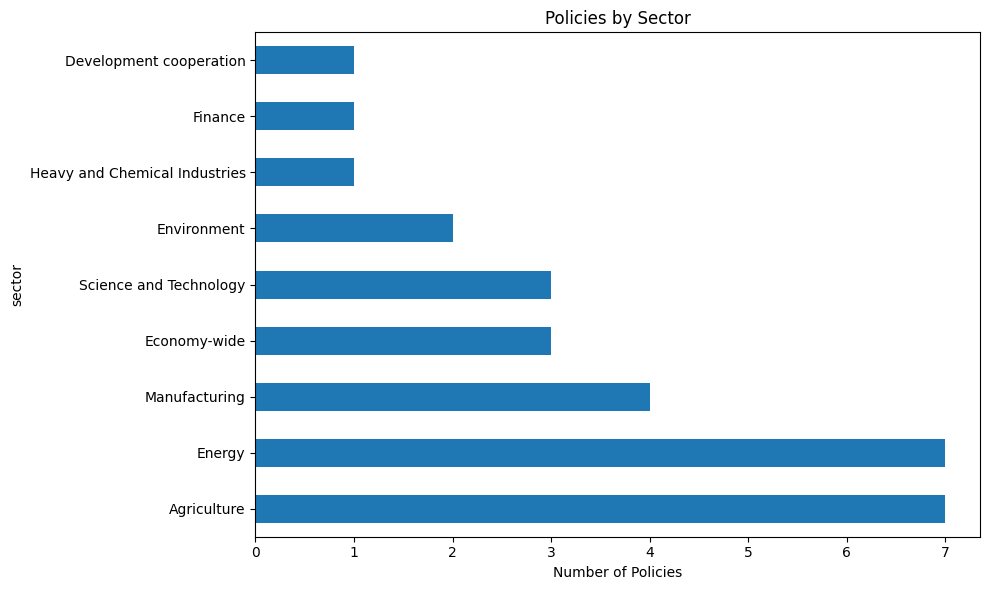


✓ Saved sector distribution chart


/tmp/ipython-input-1919891986.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


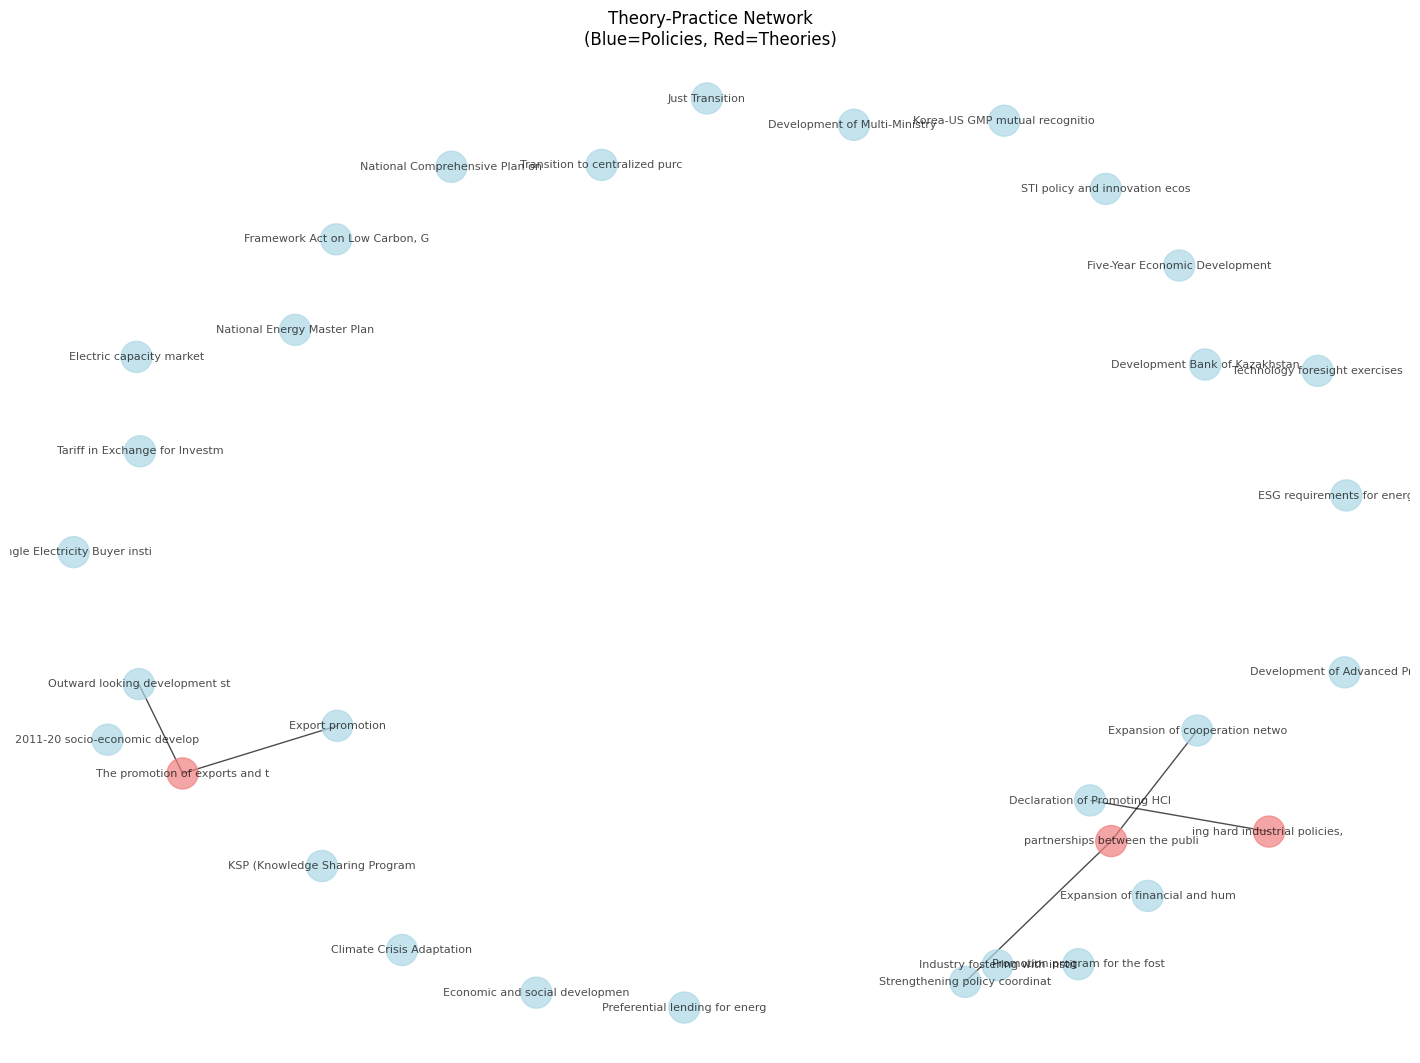

✓ Saved theory-practice network


In [26]:
# Run analysis
if 'extracted_policies' in locals() and extracted_policies:
    policy_df = analyze_policies(extracted_policies)

## Section 13: Summary & Next Steps

In [27]:
print("\n" + "="*60)
print("PILOT STUDY COMPLETE")
print("="*60)

print(f"\nResults saved in: {config.project_dir}")
print("\nKey outputs:")
print(f"  1. Processed chunks: {config.processed_dir}/")
print(f"  2. Vector database: {config.vector_db_dir}/")
print(f"  3. Extracted policies: {config.results_dir}/extracted_policies.json")
print(f"  4. Visualizations: {config.results_dir}/*.png")

if 'eval_results' in locals():
    print(f"\n  Overall F1 Score: {eval_results['overall']['f1']:.3f}")
    if eval_results['overall']['f1'] >= 0.70:
        print("  \u2713 Pilot successful! Ready to scale to full 566 reports")
    else:
        print("  \u26a0 Consider refining prompts or chunking strategy")

print("\nNext steps:")
print("  1. Review extracted policies for quality")
print("  2. Create gold standard annotations if not done")
print("  3. Refine extraction prompts based on errors")
print("  4. Scale to full dataset (566 reports)")

print("\n" + "="*60)


PILOT STUDY COMPLETE

Results saved in: /content/drive/MyDrive/KM4D_v0

Key outputs:
  1. Processed chunks: /content/drive/MyDrive/KM4D_v0/data/processed/
  2. Vector database: /content/drive/MyDrive/KM4D_v0/vector_db/
  3. Extracted policies: /content/drive/MyDrive/KM4D_v0/data/results/extracted_policies.json
  4. Visualizations: /content/drive/MyDrive/KM4D_v0/data/results/*.png

Next steps:
  1. Review extracted policies for quality
  2. Create gold standard annotations if not done
  3. Refine extraction prompts based on errors
  4. Scale to full dataset (566 reports)

